# AMMI Day 10

## Morning Session
### Transfer Learning for Computer Vision

In [1]:
!pip install tensorflow-gpu==2.0.0-beta0

     |████████████████████████████████| 348.9MB 34kB/s 
     |████████████████████████████████| 3.1MB 47.4MB/s 
     |████████████████████████████████| 501kB 52.6MB/s 


In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import pandas as pd
import numpy as np

print(tf.__version__)

2.0.0-beta0


In [0]:
LIST_OF_LABELS = "cirrus,cumulonimbus,cumulus".split(',')
HEIGHT = 300
WIDTH = 300
NUM_CHANNELS = 3
NCLASSES = len(LIST_OF_LABELS)
BATCH_SIZE = 32

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Get a list of files and their classes

In [0]:
_path = '/content/gdrive/My Drive/clouds/'
_files = list()
_classes = list()

for i in range(1,21):
  _files.append('{}cirrus/{}.jpg'.format(_path,i))
  _classes.append(0)
  _files.append('{}cumulonimbus/{}.jpg'.format(_path,i))
  _classes.append(1)
  _files.append('{}cumulus/{}.jpg'.format(_path,i))
  _classes.append(2)

### Load and preprocess images

In [0]:
def preprocess_image(image):
  image = tf.image.decode_image(contents=image, channels=NUM_CHANNELS, expand_animations=False)
  image = tf.image.resize(image, [HEIGHT, WIDTH])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [9]:
filename = _files[1]
img = tf.io.read_file(filename)
#img = tf.image.decode_image(contents=img, channels=NUM_CHANNELS, expand_animations=False)
img = preprocess_image(img)
print(img)

tf.Tensor(
[[[0.07364706 0.18345098 0.26972547]
  [0.06332026 0.1848889  0.26724184]
  [0.07450981 0.18431373 0.27058825]
  ...
  [0.00196078 0.04509804 0.1627451 ]
  [0.00784314 0.05098039 0.16078432]
  [0.00784314 0.05098039 0.16078432]]

 [[0.07192157 0.18172549 0.26799998]
  [0.06949019 0.19105883 0.27341178]
  [0.07254902 0.18235295 0.26862746]
  ...
  [0.00196078 0.04509804 0.1627451 ]
  [0.00784314 0.05098039 0.16078432]
  [0.00784314 0.05098039 0.16078432]]

 [[0.0696732  0.17947713 0.26575166]
  [0.07542484 0.19699347 0.27934638]
  [0.07843138 0.1882353  0.27450982]
  ...
  [0.00196078 0.04509804 0.1627451 ]
  [0.00784314 0.05098039 0.16078432]
  [0.00784314 0.05098039 0.16078432]]

 ...

 [[0.5960782  0.6385619  0.6792155 ]
  [0.         0.00392157 0.        ]
  [0.05751546 0.06588147 0.06718858]
  ...
  [0.34418312 0.4526798  0.4887583 ]
  [0.0015686  0.00640522 0.00418294]
  [0.         0.00915037 0.        ]]

 [[0.48533326 0.5390587  0.5778037 ]
  [0.0086275  0.00894117 0

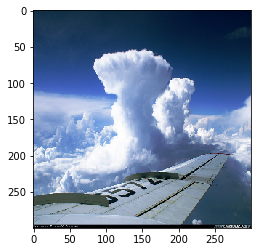

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

### Image Preprocessing

In [11]:
path_ds = tf.data.Dataset.from_tensor_slices(_files)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
image_ds

<ParallelMapDataset shapes: (300, 300, None), types: tf.float32>

In [12]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(_classes, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((300, 300, None), ()), types: (tf.float32, tf.int64)>

In [13]:
ds = image_label_ds.shuffle(buffer_size=1000 * BATCH_SIZE)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 300, 300, None), (None,)), types: (tf.float32, tf.int64)>

### LeNet-5

In [14]:
model = models.Sequential([
    layers.Conv2D(filters=6, kernel_size=(5,5), strides=1, activation='tanh', input_shape=(HEIGHT, HEIGHT, NUM_CHANNELS)),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, activation='tanh'),
    layers.AveragePooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(120),
    layers.Dense(84),
    layers.Dense(NCLASSES)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 148, 148, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 72, 72, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               9953400   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds, epochs=5, steps_per_epoch=60)

Epoch 1/5
60/60 [==============================] - 58s 960ms/step - loss: 10.7454 - accuracy: 0.3333
Epoch 2/5
60/60 [==============================] - 52s 873ms/step - loss: 10.7454 - accuracy: 0.3333
Epoch 3/5
60/60 [==============================] - 53s 875ms/step - loss: 10.7454 - accuracy: 0.3333
Epoch 4/5
60/60 [==============================] - 52s 868ms/step - loss: 10.7454 - accuracy: 0.3333
Epoch 5/5
60/60 [==============================] - 52s 874ms/step - loss: 10.7454 - accuracy: 0.3333


### VGG Architecture

In [18]:
model = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), bias_initializer=tf.initializers.zeros(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.zeros(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(4096, activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu', bias_initializer=tf.initializers.ones(), kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0, stddev=0.01)),
    layers.Dense(NCLASSES, activation='softmax', bias_initializer=tf.initializers.ones())
])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 384)      

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds, epochs=5, steps_per_epoch=60)

### VGG Pre-trained

In [20]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False
print(base_model.summary())

80142336/80134624 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
______________________________________________________________

In [21]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NCLASSES, activation='softmax')
])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 9, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 20,090,435
Trainable params: 66,051
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds, epochs=5, steps_per_epoch=60)

Epoch 1/5
60/60 [==============================] - 60s 998ms/step - loss: 0.9291 - accuracy: 0.5500
Epoch 2/5
60/60 [==============================] - 54s 901ms/step - loss: 0.7036 - accuracy: 0.6958
Epoch 3/5
60/60 [==============================] - 54s 905ms/step - loss: 0.5936 - accuracy: 0.7568
Epoch 4/5
60/60 [==============================] - 54s 904ms/step - loss: 0.5574 - accuracy: 0.7656
Epoch 5/5
60/60 [==============================] - 54s 905ms/step - loss: 0.5016 - accuracy: 0.8083


### Functional API

In [23]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds, epochs=10, steps_per_epoch=60)

Epoch 1/10
60/60 [==============================] - 60s 1s/step - loss: 0.8066 - accuracy: 0.6359
Epoch 2/10
60/60 [==============================] - 55s 909ms/step - loss: 0.4878 - accuracy: 0.8359
Epoch 3/10
60/60 [==============================] - 55s 909ms/step - loss: 0.3394 - accuracy: 0.9036
Epoch 4/10
60/60 [==============================] - 54s 908ms/step - loss: 0.2507 - accuracy: 0.9359
Epoch 5/10
60/60 [==============================] - 54s 902ms/step - loss: 0.1742 - accuracy: 0.9531
Epoch 6/10
60/60 [==============================] - 54s 904ms/step - loss: 0.1301 - accuracy: 0.9719
Epoch 7/10
60/60 [==============================] - 54s 895ms/step - loss: 0.1032 - accuracy: 0.9818
Epoch 8/10
60/60 [==============================] - 54s 898ms/step - loss: 0.0844 - accuracy: 0.9849
Epoch 9/10
60/60 [==============================] - 54s 896ms/step - loss: 0.0686 - accuracy: 0.9880
Epoch 10/10
60/60 [==============================] - 54s 900ms/step - loss: 0.0612 - accuracy:

## Afternoon Session
### Cloud ML Engine
### Hyperparameter Tuning
### Distributed Training